In [554]:
import pandas as pd
import numpy as np
from plotly.graph_objects import *
from plotly.offline import init_notebook_mode,iplot
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.arima.model  import ARIMA
from sklearn.metrics import r2_score,mean_absolute_error
from sklearn.model_selection import TimeSeriesSplit
import warnings
warnings.filterwarnings('ignore')

Данные
======
Данные представляют собой количество заказазов в день в одной из столовых города Мюнхен. 

На выбор клиенты могут заказать одно из трех меню. Данные собраны для каждого меню отдельно (колонка item_descr). 

In [555]:
# import dataframe
df = pd.read_csv('../datatest/kmf.csv')

Домашнее задание 
======

ARIMA
----
* На выбор построить общую модель количества заказов в день илбо разделить данные на три временных ряда для каждого меню отдельно
* В случае общей модели данные нужно агрегировать, чтобы посчитать общее количество заказов за день
* По желанию можно можно сменить частоту с дня на неделю или месяц
* Построить графики ACF и PACF. 
* Построить модель ARIMA и сделать кросс-валидацию
* Сделать отчет по выбранным метрикам


Регрессия (опционально)
-------
С этими же данными построить регрессионную модель, используя feature engineering из прошлой лекции

In [556]:
df['from_date']=pd.to_datetime(df['from_date'])
df.set_index('from_date',inplace=True)

# Суммируем по месяцам

In [557]:
df = df.resample('M').sum()
df.rename(columns = {'amount' : 'sum'}, inplace = True) 

In [558]:
df=df[:-1] #уберем неполные данные

<AxesSubplot:xlabel='from_date'>

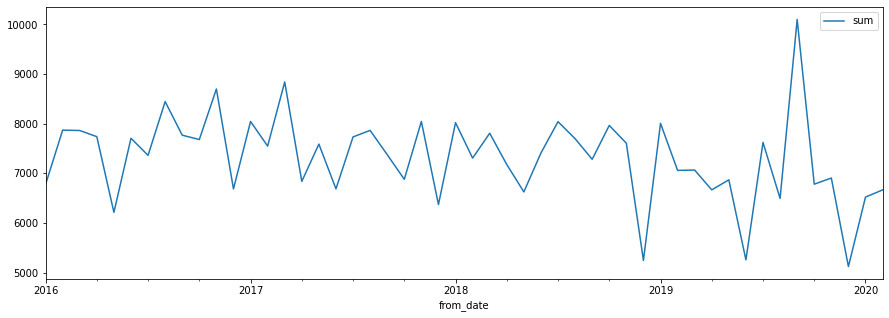

In [559]:
plt.rcParams['figure.figsize'] = [15,5]
df.plot()

In [560]:
#df['diff']=df['sum'].diff(periods=1)

# Автокорреляция (AC)

In [561]:
df_ac = df.copy()
for i in range(1,13):
    df_ac[f'lag-{i}'] = df_ac['sum'].shift(i)

In [562]:
(df_ac.corr()['sum']).sort_values(ascending=False)

sum       1.000000
lag-12    0.406036
lag-6     0.374923
lag-2     0.236309
lag-8     0.226435
lag-4     0.141916
lag-7     0.078419
lag-11    0.058777
lag-10    0.013017
lag-5    -0.090604
lag-1    -0.117813
lag-9    -0.249482
lag-3    -0.343188
Name: sum, dtype: float64

In [563]:
acf_results = acf(df_ac['sum'],nlags=30,fft=False, missing='drop')

In [564]:
acf_results

array([ 1.        , -0.11651857,  0.23114231, -0.31238421,  0.12572561,
       -0.0795261 ,  0.28965683,  0.05923199,  0.1670199 , -0.1721347 ,
        0.00168706,  0.02406746,  0.24258973, -0.01763098,  0.03446907,
       -0.05577099, -0.10653219, -0.01470017,  0.06453856, -0.01454691,
        0.13228873, -0.18063964,  0.03126939, -0.06776027,  0.14981005,
       -0.11727115,  0.05897261, -0.19068839, -0.01942745, -0.14041005,
        0.10563576])

In [565]:
traces = list()
for i in range(len(acf_results)):
    traces.append(Scatter(x=[i,i],
                         y = [0,acf_results[i]],
                         showlegend=False,
                         line = {'color':'red'}))
fig = Figure(data=traces)
fig.show()

# Частичная автокорреляция (PAC)

In [566]:
df_pac = df.copy()
pacf_results = pacf(df_pac['sum'],nlags=20, method = 'ols')

In [567]:
pacf_results

array([ 1.        , -0.11801922,  0.22702158, -0.32316119,  0.02460269,
        0.05157757,  0.37167629,  0.2587927 ,  0.21535223, -0.26510377,
       -0.28957364,  0.1218327 ,  0.44962416,  0.20112244,  0.02007461,
        0.22492488, -0.02505736,  0.10426454,  0.11007051, -0.46498825,
        0.97772252])

In [568]:
df_pac = df.copy()

In [569]:
traces = list()
for i in range(len(pacf_results)):
    traces.append(Scatter(x=[i,i],
                         y = [0,pacf_results[i]],
                         showlegend=False,
                         line = {'color':'red'}))
fig = Figure(data=traces)
fig.show()


# ARIMA и кросс-валидация

In [570]:
model = ARIMA(df['sum'], order=(1, 0, 1))  
print(model.fit().summary())

                               SARIMAX Results                                
Dep. Variable:                    sum   No. Observations:                   50
Model:                 ARIMA(1, 0, 1)   Log Likelihood                -407.379
Date:                Wed, 22 Dec 2021   AIC                            822.757
Time:                        06:17:02   BIC                            830.405
Sample:                    01-31-2016   HQIC                           825.670
                         - 02-29-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       7319.4280    138.861     52.710      0.000    7047.265    7591.591
ar.L1         -0.9606      0.149     -6.433      0.000      -1.253      -0.668
ma.L1          0.8584      0.273      3.140      0.0

In [571]:
# ARIMA - model (p=1, i = 1, q = 1)
mod = ARIMA(df['sum'],
           order=(1,1,1))
predictions = mod.fit().predict()

trace1 = Scatter(x = df.index,
                y = df['sum'],
                name = 'Original data')
trace2 = Scatter(x = df.index,
                y=predictions,
                name = 'Predictions')
r2 = np.round(r2_score(df['sum'],predictions),2)
mae = np.round(mean_absolute_error(df['sum'],predictions),2)
fig = Figure(data=[trace1,trace2],
            layout=Layout(title = f'r2={r2}, mae = {mae}'))
fig.show()

In [572]:
# AR - model (p=1, i = 0, q = 0)
from sklearn.metrics import r2_score,mean_absolute_error
mod = ARIMA(df['sum'],
           order=(1,0,0))
predictions = mod.fit().predict()

trace1 = Scatter(x = df.index,
                y = df['sum'],
                name = 'Original data')
trace2 = Scatter(x = df.index,
                y=predictions,
                name = 'sum')
r2 = np.round(r2_score(df['sum'],predictions),2)
mae = np.round(mean_absolute_error(df['sum'],predictions),2)
fig = Figure(data=[trace1,trace2],
            layout=Layout(title = f'r2={r2}, mae = {mae}'))
fig.show()

In [573]:
# ARMA - model (p=1, i = 0, q = 1)
mod = ARIMA(df['sum'],
           order=(1,0,1))
predictions = mod.fit().predict()

trace1 = Scatter(x = df.index,
                y = df['sum'],
                name = 'Original data')
trace2 = Scatter(x = df.index,
                y=predictions,
                name = 'Predictions')
r2 = np.round(r2_score(df["sum"],predictions),2)
mae = np.round(mean_absolute_error(df["sum"],predictions),2)
fig = Figure(data=[trace1,trace2],
            layout=Layout(title = f'r2={r2}, mae = {mae}'))
fig.show()

In [574]:
tscv = TimeSeriesSplit(test_size = 8)
mae_list = list()
r2_list = list()
    
for train_index, test_index in tscv.split(df['sum']):
    train, test = df['sum'][train_index], df['sum'][test_index]
    mod = ARIMA(train,
           order=(1,0,1))
    predictions = mod.fit().forecast(len(test))
    mae_list.append(mean_absolute_error(test,predictions))
    r2_list.append(r2_score(test,predictions))
    #print("%20f%20f" % ( np.mean(mae_list),np.mean(r2_list)))
print('{mae}:{mael:^18}|{r2:2}:{r2l:^18}'.format(mae="mae",mael=np.mean(mae_list),r2="r2",r2l=np.mean(r2_list)))

mae: 692.462067676414 |r2:-0.17753192731037248


Наиболее оптимальые модели ARIMA с параметрами p=1, i = 0, q = 1 и p=1, i = 1, q = 1  но и с ними r2 далек от 1.